In [1]:
import qiskit
import qiskit_aer

**What is the BB84 protocol?**

It is a protocol used to share keys among two correspondents(Alice and Bob) securely. 

**How is this done?**

There are 2 different basis states that you can use to measure the qubit in. 
Alice(the sender) randomly chooses one of the basis to prepare the qubit in(let's consider X and Z in this case) and sends over the qubit to Bob. Bob chooses randomly one of the basis to measure in and consequently, alice and bob compare notes on which basis they measured the qubit in(i.e b=b' or b!=b'). If b=b' then 'a' is the same as the the measured state a'. Alice and Bob keep the a' bits where b=b'and discards teh others.

In this case, the secret key that both alice and bob share is the 'a' bit. This can be done multiple times to have a key of a certain length. The circuit looks like this:
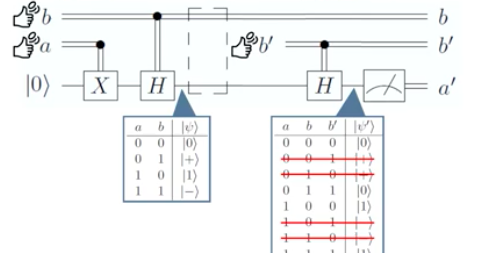

In [316]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import StatevectorSimulator, AerSimulator
import numpy as np 
import matplotlib.pyplot as plt

In [400]:
num_qub=10#arbitrary size of the key to be distributed
a=np.random.randint(2, size=num_qub) #key
b=np.random.randint(2, size=num_qub)#choice of alice's basis to measure

b_prime=np.random.randint(2, size=num_qub) #bob's choice of basis for measuring


print(a,b,b_prime)

[0 1 0 0 0 1 1 1 0 0] [0 1 1 0 0 0 1 1 1 1] [0 0 1 0 0 0 1 1 0 1]


In [369]:
%matplotlib inline

def circuit(alice_state, alice_basis, bob_basis):
    num_qub=len(alice_basis)
    
    qc=QuantumCircuit(num_qub)
    for i in range(num_qub):
        if alice_state[i]==1:
            qc.x(i)  #|0> or |1> basis
        if alice_basis[i]==1:   #this decides which basis to encode alice's message in
            qc.h(i)  #this is the |+>, |-> basis
            
            
    for i in range(len(bob_basis)):
        if bob_basis[i]==1:
            qc.h(i)  #decide to measure in the hadamard basis
    
    qc.measure_all()
    qc.draw(output='mpl')
    plt.show()
    return qc
    
   


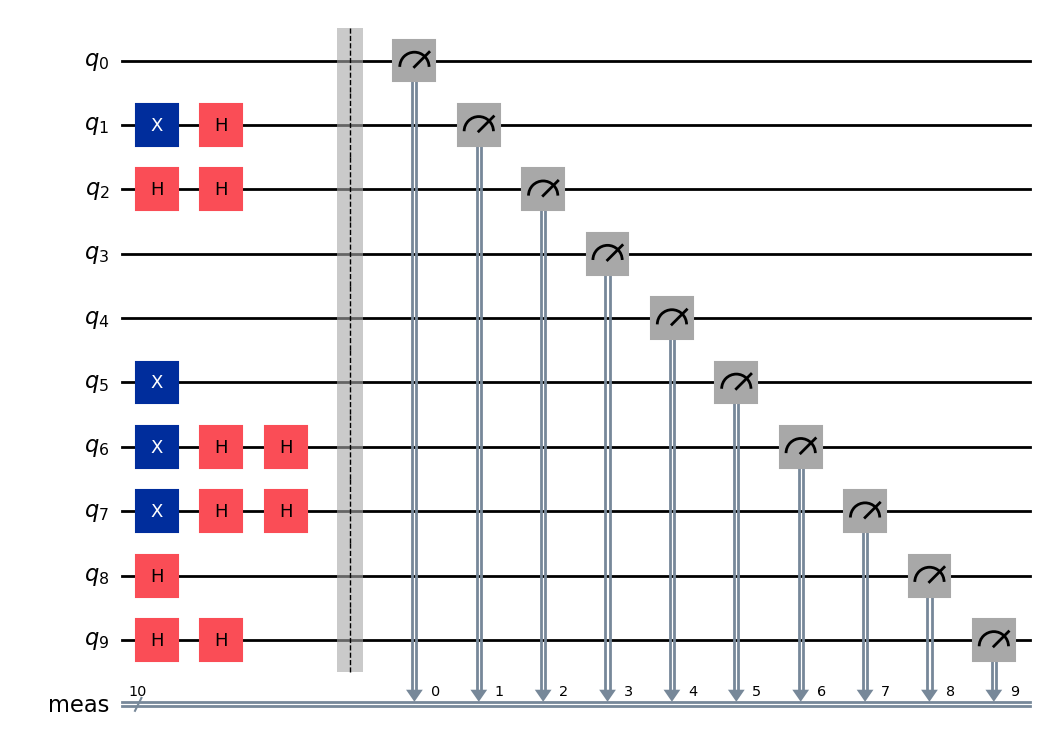

In [401]:
qc=circuit(a,b,b_prime) #a look at the circuit

In [402]:
job=AerSimulator().run(qc,shots=1024 )
counts=job.result().get_counts(qc).most_frequent() #gives most probable bitstring



bob_encryption_key = ''
alice_key=''
for i in range(num_qub):
    if b[i] == b_prime[i]:
         bob_encryption_key += str(counts[i])
         alice_key+= str(a[i]) #alice discards bits where the bases don't match
         
bob_encryption_key=bob_encryption_key[::-1] #reversing because the qiskit stores the measurement in the little endian format

print(f"Alice's Key: {alice_key}")
print(f"Bob's Key: {bob_encryption_key}")


Alice's Key: 00001110
Bob's Key: 00001110


**Quantum Bit Rate Error**

Here Alice and Bob measure a portion of their keys and compare how many of the bits in the key match. If it's below a certain rate(say 11%), we can be considerably sure that there's no eavesdropper. This error rate is the QBER. In this case, there's no noise or eavesdropper(very ideal case)- and hence you would expect to see an error rate of 0. 

In [403]:

import random
portionToConsider=0.2 #this can be changed accordingly
lenToConsider=max(1, int(portionToConsider*len(bob_encryption_key)))

sample_inds=random.sample(range(len(bob_encryption_key)), lenToConsider) #consider a random subset of the key
error_count=0
for i in sample_inds:
    if bob_encryption_key[i]!=alice_key[i]:
        error_count+=1
qber= error_count/lenToConsider
print(f"Error Rate: {qber}")

Error Rate: 0.0


**The E91 Protocol**

This protocol is a QKD protocol that uses entanglement as a key concept. 2 photons are maximally entangled in such a way that if Alice measures 0 then Bob measures 1 and vice versa. In this case, there are 3 measurement basis that correspond to the rotation of {|0>,|1>} by angles of {a1, a2, a3} degrees for alice and {b1, b2 , b3} degrees for Bob. Notice that a2=b1 and a3=b2. This means that we have 4 distinct meaasurement basis.

So when measured in the same basis, alice and bob know for sure that they've got the opposite bits(which can be flipped by bob to get the same bits as alice).

The measurements done in differing bases can be used to calculate a correlation coefficient S.
If |S|<=2 (which means the qubits are no longer entangled), implies there's an eavesdropper
ans |S|=2root(2) implies the channel is secure, with maximal entanglement

**Singlet preparation**

I'm preparing Β11 entangled state here as the singlet

In [80]:
def singlet(qc):
    qc.x(0)
    qc.x(1)
    qc.h(0)
    qc.cx(0,1)
    return qc
    
    


Here, I'm considering the 4 different measurement basis as X, Z, V and W.

In [130]:
def a1(qc, q, c):  #X-basis
    qc.h(0)
    qc.measure(q[0], c[0])
    return qc
    
def a2(qc, q, c):  #W-basis
    qc.s(0)  
    qc.h(0)
    qc.t(0)
    qc.h(0)
    qc.measure(q[0], c[0])
    return qc

def a3(qc, q,c):   #Z-basis
    qc.measure(q[0], c[0])
    return qc


def b1(qc, q,c): #W-basis
   
    qc.s(1)  
    qc.h(1)
    qc.t(1)
    qc.h(1)
    qc.measure(q[1], c[1])
    return qc

def b2(qc,q,c):  #Z-basis
    qc.measure(q[1], c[1])
    return qc

def b3(qc,q,c):  #V-basis
    qc.s(1)  
    qc.h(1)
    qc.tdg(1)
    qc.h(1)
    qc.measure(q[1], c[1])
    return qc

alice_mb=['a1','a2','a3']
bob_mb=['b1','b2','b3']
    
    


In [283]:
n_singlets=20
alice_stores=[] #stores the measurements from alice
bob_stores=[] #stores measurements from bob
alice_choices=[]# alice's basis choices
bob_choices=[] #bob's basis choices

In [284]:
for j in range(n_singlets):
    alice_measures= random.choice(alice_mb)  
    bob_measures= random.choice(bob_mb)  
    alice_choices.append(alice_measures)
    bob_choices.append(bob_measures)

    
    q=QuantumRegister(2)
    c=ClassicalRegister(2)
    qc=QuantumCircuit(q,c)

    qc=singlet(qc)
    if alice_measures=='a1':
        a1(qc,q,c)
    elif alice_measures=='a2':
        a2(qc,q,c)
    elif alice_measures=='a3':
        a3(qc,q,c)
    
    if bob_measures=='b1':
        b1(qc,q,c)
    elif bob_measures=='b2':
        b2(qc,q,c)
    elif bob_measures=='b3':
        b3(qc,q,c)
    qc.draw()   
    job=AerSimulator().run(qc,shots=1024 )
    counts=job.result().get_counts(qc)
    
    result = list(counts.keys())[0]
    alice_stores.append(result[1])
    bob_stores.append(result[0])



In [280]:
#Just for debugging/confirmations
print(alice_stores)
print(bob_stores)

print(alice_choices)
print(bob_choices)

['1', '0', '1', '0', '1', '1', '1', '1', '1', '1']
['0', '0', '0', '1', '1', '0', '0', '0', '0', '0']
['a3', 'a3', 'a1', 'a2', 'a2', 'a2', 'a1', 'a2', 'a2', 'a3']
['b3', 'b3', 'b3', 'b1', 'b2', 'b1', 'b3', 'b3', 'b2', 'b1']


In [274]:
def calc_chsh(alice_choices, bob_choices, alice_stores, bob_stores):
   
    countA1B1 = [0, 0, 0, 0]  # XW observable
    countA1B3 = [0, 0, 0, 0]  # XV observable
    countA3B1 = [0, 0, 0, 0]  # ZW observable
    countA3B3 = [0, 0, 0, 0]  # ZV observable
    for i in range(len(alice_choices)):
        print(f"Round {i}: Alice choice = {alice_choices[i]}, Bob choice = {bob_choices[i]}, Alice result = {alice_stores[i]}, Bob result = {bob_stores[i]}")
    
    for i in range(len(alice_choices)):
        res = (alice_stores[i], bob_stores[i])  # Get measurement result (Alice, Bob)

        # Check which basis was used and update corresponding counts
        if alice_choices[i] == 'a1' and bob_choices[i] == 'b1':
            if res == ('0', '0'): countA1B1[0] += 1
            elif res == ('0', '1'): countA1B1[1] += 1
            elif res == ('1', '0'): countA1B1[2] += 1
            elif res == ('1', '1'): countA1B1[3] += 1

        if alice_choices[i] == 'a1' and bob_choices[i] == 'b3':
            if res == ('0', '0'): countA1B3[0] += 1
            elif res == ('0', '1'): countA1B3[1] += 1
            elif res == ('1', '0'): countA1B3[2] += 1
            elif res == ('1', '1'): countA1B3[3] += 1

        if alice_choices[i] == 'a3' and bob_choices[i] == 'b1':
            if res == ('0', '0'): countA3B1[0] += 1
            elif res == ('0', '1'): countA3B1[1] += 1
            elif res == ('1', '0'): countA3B1[2] += 1
            elif res == ('1', '1'): countA3B1[3] += 1

        if alice_choices[i] == 'a3' and bob_choices[i] == 'b3':
            if res == ('0', '0'): countA3B3[0] += 1
            elif res == ('0', '1'): countA3B3[1] += 1
            elif res == ('1', '0'): countA3B3[2] += 1
            elif res == ('1', '1'): countA3B3[3] += 1

    # Compute expectation values
    def expectation(counts):
        total = sum(counts)
        if total == 0: return 0  
        return (counts[0] - counts[1] - counts[2] + counts[3]) / total

    expectA1B1 = expectation(countA1B1)
    expectA1B3 = expectation(countA1B3)
    expectA3B1 = expectation(countA3B1)
    expectA3B3 = expectation(countA3B3)
    print("countA1B1:", countA1B1)
    print("countA1B3:", countA1B3)
    print("countA3B1:", countA3B1)
    print("countA3B3:", countA3B3)
    print("E(A1, B1):", expectA1B1)
    print("E(A1, B3):", expectA1B3)
    print("E(A3, B1):", expectA3B1)
    print("E(A3, B3):", expectA3B3)

  


    # Compute CHSH correlation value
    chsh_value = expectA1B1 - expectA1B3 + expectA3B1 + expectA3B3
    print(f"CHSH Correlation Value: {chsh_value}")

    return chsh_value


In [86]:
def toggle(string):     #to flip bob's bits
    return string.translate(str.maketrans("01", "10"))
            
    

In [290]:
alice_key=''
bob_key=''

for i in range(len(alice_stores)):
    if (alice_choices[i]=='a2' and bob_choices[i]=='b1') or (alice_choices[i]=='a3' and bob_choices[i]=='b2'):
        alice_key+=str(alice_stores[i])
        bob_key+=str(bob_stores[i])
   
    



In [291]:
bob_key=toggle(bob_key)
print(f"Bob's key: {bob_key}")
print(f"Alice's key: {alice_key}")

Bob's key: 0010
Alice's key: 0010


**QBER**

The Bit error rate is calcualted similarly to the previous instance, where you check how many errors bob's key has compared to alice's.

In [289]:

import random
portionToConsider=1 #this can be changed accordingly
lenToConsider=max(1, int(portionToConsider*len(bob_key)))

sample_inds=random.sample(range(len(bob_key)), lenToConsider) #consider a random subset of the key
error_count=0
for i in sample_inds:
    if bob_key[i]!=alice_key[i]:
        error_count+=1
qber= error_count/lenToConsider
print(f"Error Rate: {qber}")

Error Rate: 0.0


**Future Work**

In these implementation of the QKD protocols, we haven't considered the eavesdropper's presence in the simulation itself- that can be implemented in a future iteration.



**References:**

1. https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/e91_qkd/e91_quantum_key_distribution_protocol.ipynb

2. https://github.com/kardashin/E91_protocol/blob/master/E91_simulator.ipynb

3. https://github.com/qmunitytech/Tutorials/blob/main/intermediate/The%20BB84%20Quantum%20Cryptography%20algorithm.ipynb

4. https://www.youtube.com/watch?v=u_K9jPBrOwA&t=980s

5. Nielsen & Chuang